### Desperately Seeking Silver

We are going to focus on the 2012 Presidential election.

We are going to focus on the 2012 Presidential election. Analysts like Nate Silver, Drew Linzer, and Sam Wang developed highly accurate models that correctly forecasted most or all of the election outcomes in each of the 50 states. We will explore how hard it is to recreate similarly successful models.

Outcomes:

1. To practice data manipulation with Pandas
2. To develop intuition about the interplay of **precision**, **accuracy**, and **bias** when making predictions
3. To better understand how election forecasts are constructed


In [1]:
"""   helper python script that contains the following :

- dark2_colors : a (rgb) color palette
- remove_border
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
- draw_state
    Automatically draws a filled shape representing the state in subplot.
- make_map
    Draw a cloropleth map, that maps data onto the United States
"""
%run hw2.py

In [2]:
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd


In [3]:
from matplotlib.rcsetup import cycler

mpl.rc('figure', figsize=(10,6), dpi=150)
mpl.rc('axes', facecolor='white', 
       prop_cycle=cycler('color', dark2_colors ))
mpl.rc('lines', lw=2)
mpl.rc('patch', ec='white', fc=dark2_colors[0])
mpl.rc('font', size=14, family='StixGeneral')

In [4]:
# We are pretending to build our model 1 month before the election
import datetime
today = datetime.datetime(2012, 10, 2)
today

datetime.datetime(2012, 10, 2, 0, 0)

In [5]:
electoral_votes = pd.read_csv("../data/hw2_data/electoral_votes.csv").set_index('State')
electoral_votes.head()

,Votes
State,
California,55
Texas,38
New York,29
Florida,29
Illinois,20


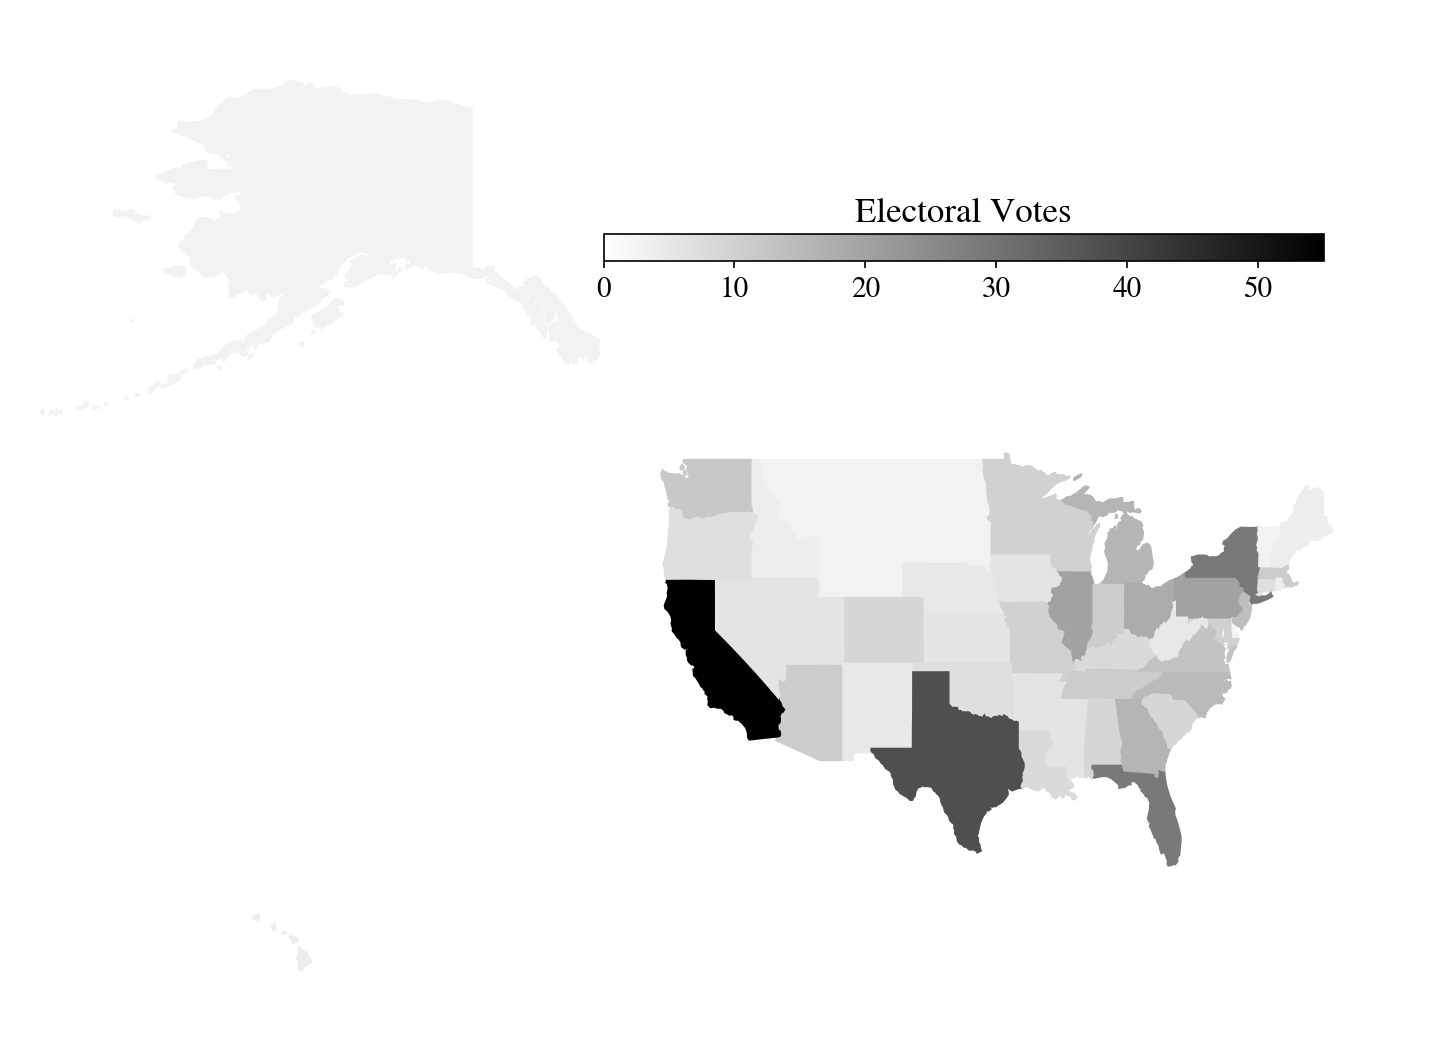

In [7]:
make_map(electoral_votes.Votes, "Electoral Votes")

### Question 1: Simulating elections

Our reference point:
[PredictWise](http://www.predictwise.com/results/2012/president)'s quite successful forecast, released on October 2, 2012.

PredictWise aggregated polling data and, for each state, estimated the probability that the Obama or Romney would win. Here are those estimated probabilities:


In [8]:
predictwise = pd.read_csv('../data/hw2_data/predictwise.csv').set_index('States')
predictwise.head()


,Obama,Romney,Votes
States,,,
Alabama,0.000,1.000,9
Alaska,0.000,1.000,3
Arizona,0.062,0.938,11
Arkansas,0.000,1.000,6
California,1.000,0.000,55


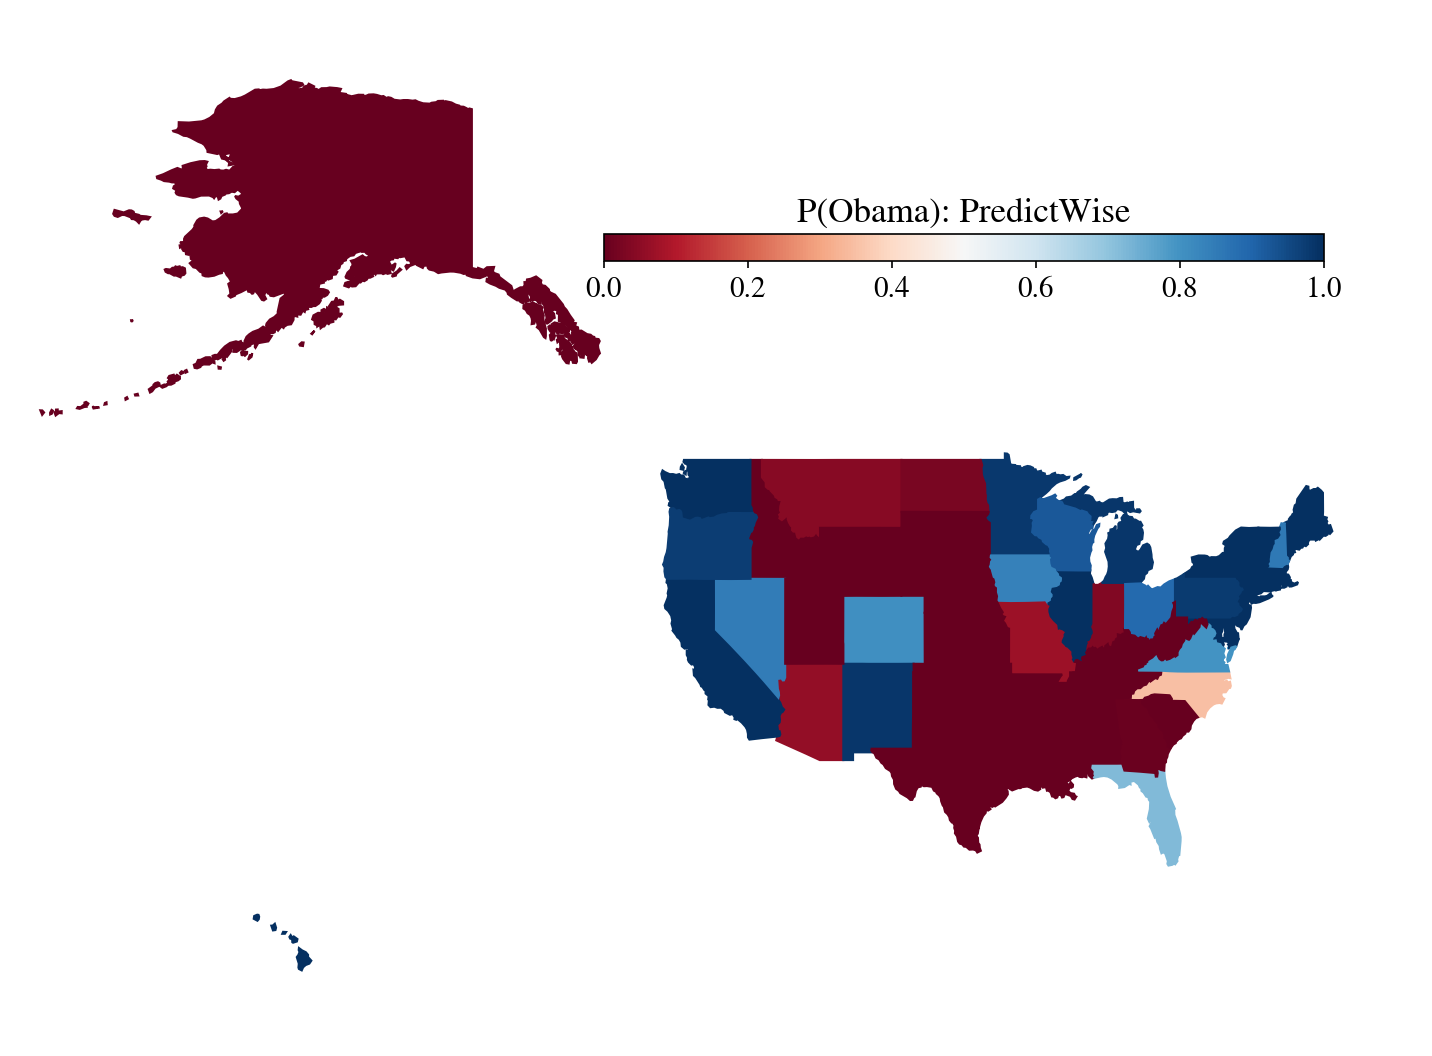

In [9]:
# Using make_map, plot the probability that
# Obama wins each state, according to this prediction.
make_map(predictwise.Obama, "P(Obama): PredictWise")